# Data Analysis with Python Logs

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import os  
import shutil
import random
from sklearn.metrics import mean_squared_error
import scipy.stats as st 
import tqdm
import pickle
import csv

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 600
plt.style.use('ggplot')
random.seed(100)

In [3]:
wd = os.getcwd()
path = os.path.join(os.path.join(wd, "data"), "TSVs")

## Function Definitions

In [16]:
def get_all_drug_dfs(drg, path, wanted_jobs):
    """gets drug dfs and locations of given drug

    Args:
        drg (string): specific drug wanted
        path (string): path to list of TSV's
        wanted_jobs (list): list of jobs to search through

    Returns:
        two lists: list of dfs and list of drug locations
    """
    
    drug_loc = []
    
    for job in os.listdir(path):
        curr = os.path.join(path, job)
        
        if job in wanted_jobs:
            print(f"----------{job}----------")
            samples_rmse_curr = {}
            
            for model in tqdm.tqdm(os.listdir(curr)):
                inner = os.path.join(curr, model)
                
                for subdir, dirs, files in os.walk(inner):
                    for file in files:
                        f = os.path.join(subdir, file)
                        df = pd.read_csv(f, sep="\t")
                        
                        drug = df["Drug1"][0]
                        fold_num = subdir.split("/")[-1]
                        if drg == drug:
                            drug_loc.append((job, fold_num))

    dfs = []
    locs = []
    for j,folder in drug_loc:

        file = os.path.join(os.path.join(os.path.join(path, j), folder), "predicted.tsv")

        df = pd.read_csv(file, sep="\t")
        df["Job"] = j
        locs.append((j,folder))
        dfs.append(df)

    return dfs, locs

In [24]:
def get_data_ALL(path, wanted_jobs):
    """Get all drug data into one dictionary from all specified jobs

    Args:
        path (string): path to list of tsv's
        wanted_jobs (list): list of jobs to look through

    Returns:
        dictonary: dictionary indexed by drug name
    """
    drugs_perf = {}

    for job in os.listdir(path):
        curr = os.path.join(path, job)
        
        if job in wanted_jobs:    
            for model in tqdm.tqdm(os.listdir(curr), desc=f"{job}"):
                inner = os.path.join(curr, model)
                
                for subdir, dirs, files in os.walk(inner):
                    for file in files:
                        f = os.path.join(subdir, file)
                        df = pd.read_csv(f, sep="\t")
                        
                        drug = df["Drug1"][0]
                        
                        if drug not in drugs_perf:
                            drugs_perf[drug] = []
                            drugs_perf[drug].append(df)
                        else:
                            drugs_perf[drug].append(df)
                        
    
    drug_dict = {}
    for key, value in tqdm.tqdm(drugs_perf.items()):
        drug_dict[key] = pd.concat(value)
        
        
    return drug_dict

In [54]:
def make_multiplot(drg, path, wanted_jobs):
    
    drug_dfs, drug_jobs = get_all_drug_dfs(drg=drg, path=path, wanted_jobs=wanted_jobs)
    
    
    
    N = len(drug_dfs)
    x=np.floor(np.sqrt(N))
    y=np.ceil(N/x)
    
    print(f"TOTAL: {N}-----({x, y})")
    
    fig, ax1 = plt.subplots(int(x), int(y), squeeze=False)
    fig.subplots_adjust(hspace=0.4, wspace = 0.45)
    fig.suptitle(f"Distribution of {drg} over all Individual Jobs")
    
    k = 0
    j = 0

    for i, d in enumerate(drug_dfs):

        d["AUCError"].plot.kde(ax=ax1[k][j], 
                                grid = True, )
        d["AUCError"].plot.hist(ax=ax1[k][j],
                                density = False, 
                                bins=30, 
                                rwidth = 0.9, 
                                xlim = (-1, 1))

        ax1[k][j].set_title(f"{drug_jobs[i][0]}", size = 7)
        ax1[k][j].set_ylabel("Frequency",size = 4 )
        ax1[k][j].set_xlabel("AUC Error", size = 4)
        
        k += 1
        k = k % x
        if k == 0:
            j += 1
        j = j % y

In [56]:
drug_dict = get_data_ALL(path=path, wanted_jobs=["9000896.amn-0001"])

100%|██████████| 144/144 [00:00<00:00, 9270.03it/s]


----------9000896.amn-0001----------


100%|██████████| 144/144 [00:00<00:00, 890.02it/s]

TOTAL: 1-----((1.0, 1.0))


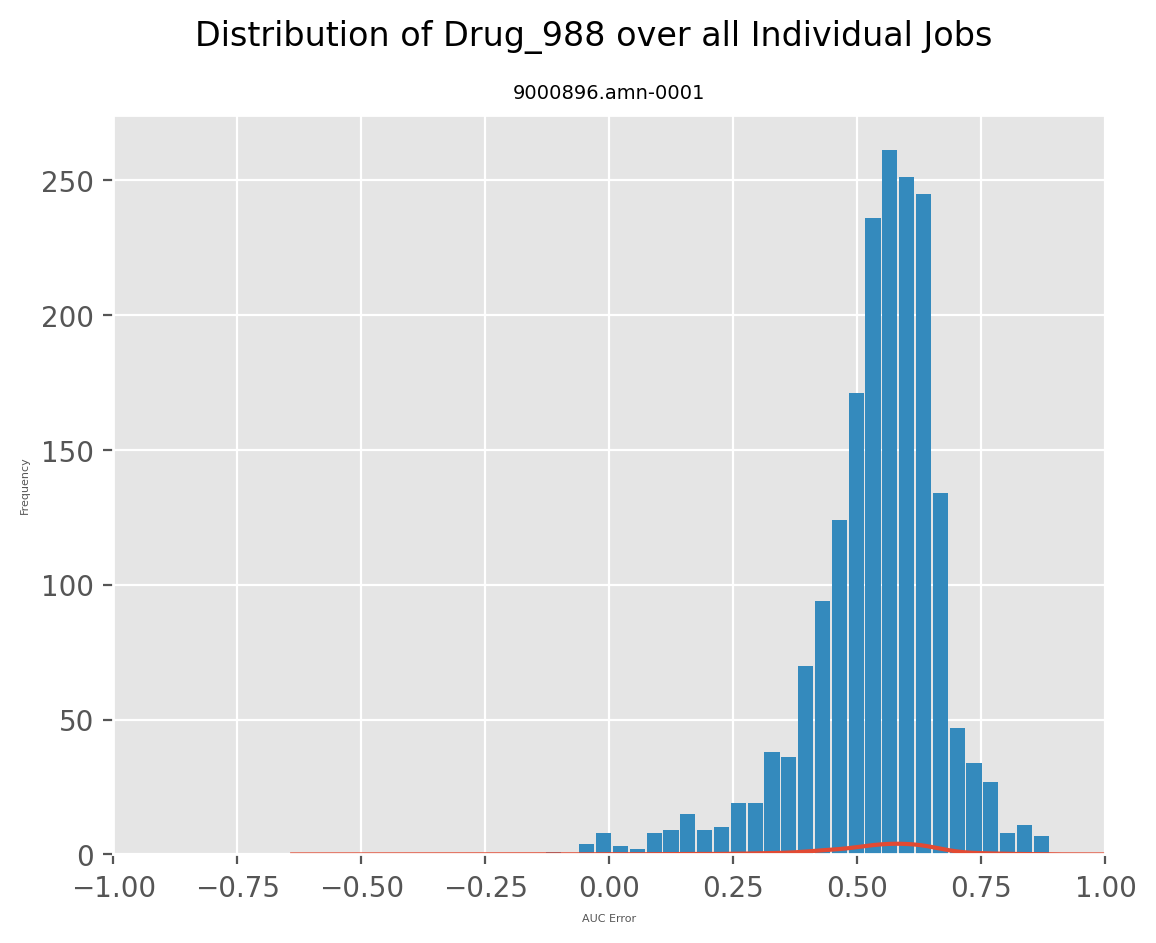

In [57]:
make_multiplot("Drug_988", path=path, wanted_jobs=["9000896.amn-0001"])

In [60]:
def make_distrib_plot(drg, d_dict):
    
    drug_df = d_dict[drg]
    
    fig, ax1 = plt.subplots()
    
    drug_df["AUCError"].plot.kde(ax=ax1, 
                            grid = True, )
    drug_df["AUCError"].plot.hist(ax=ax1,
                            density = True, 
                            bins=30, 
                            rwidth = 0.9)

    ax1.set_title(f"Distribution of AUC Errors of {drg}\nAll Specified Jobs")
    ax1.set_ylabel("")
    ax1.set_xlabel("AUC Error")

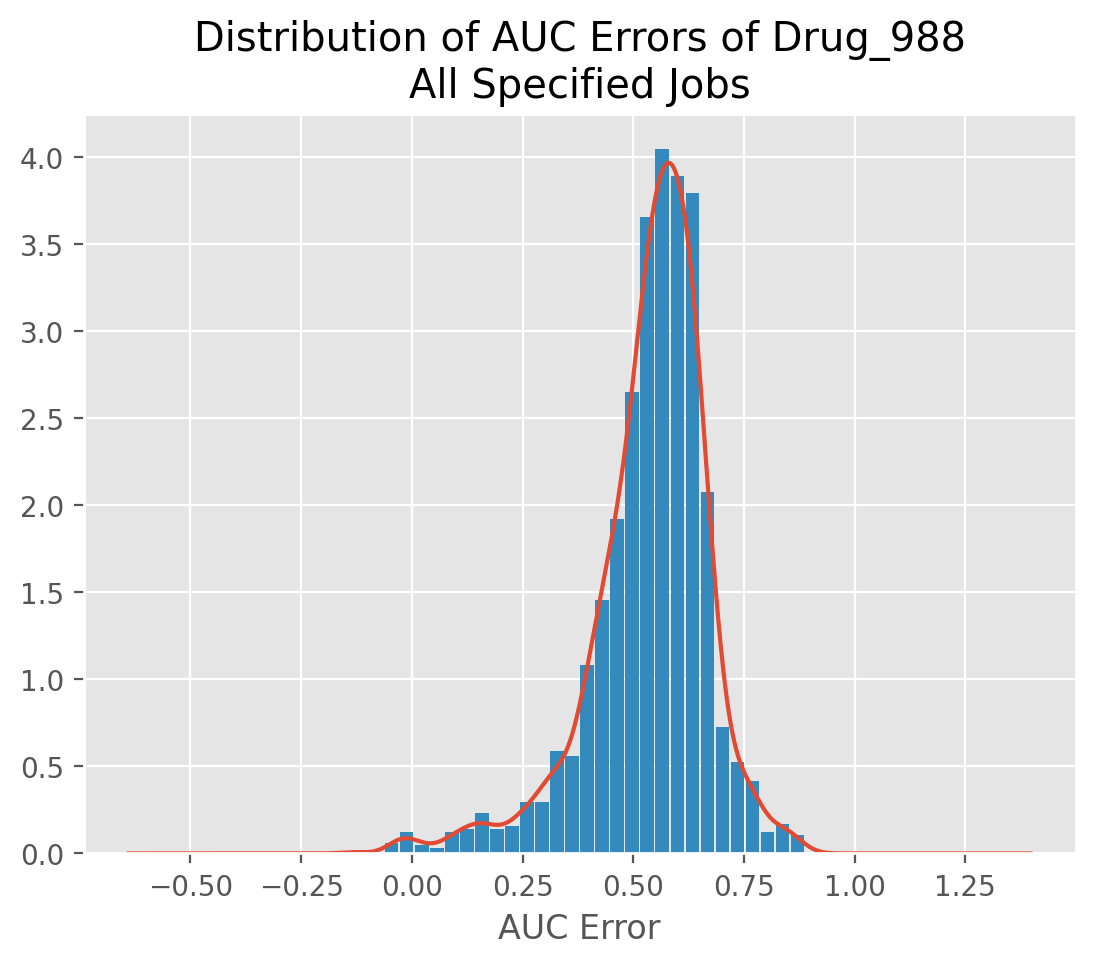

In [61]:
make_distrib_plot("Drug_988", drug_dict)